In [6]:
import datetime
import logging

import netCDF4
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import warnings
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import cftime
import os
import seaborn as sns
import cartopy
import cartopy.feature as cpf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import texttable
from tqdm.notebook import trange, tqdm
from xclim import ensembles
import global_land_mask
import iris
from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys
sys.path.append("../Farallon/QIN/CMIP6-downscale/")
sys.path.append("../Farallon/QIN/CMIP6-downscale/isimip3basd/")
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_downscale_iris
from CMIP6_model import CMIP6_MODEL
from CMIP6_plot import CMIP6_GLORYS12_plot
from cartopy.util import add_cyclic_point

In [7]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))).sortby('longitude')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,lat,lon)
    """

    # Use add_cyclic_point to interpolate input data
    lon_idx = 3 #da.dims.index('lon')

    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data,
                           coords = {'season': da.season,'period': da.period, 'lat': da.lat, 'lon': wrap_lon},
                           dims=da.dims,
                           attrs=da.attrs)

    return outp_da

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)

    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])


def get_area_averaged_ds(fname, scenario, var_name, LME, create_maps, frequency, models_dict):
    print(fname)
    if os.path.exists(fname):
        with xr.open_dataset(fname) as ds:

            ds = convert_to_180(ds)
            #ds = ds.sel(time=slice(start_time,end_time))

            #ds = convert_time(ds)
            ds_lme = get_data_within_LME(ds, var_name, LME, False)
            ds_lme = xr_add_cyclic_point(ds_lme[var_name])
            ds_lme = ds_lme.to_dataset(name=var_name)

            # Add land mask
            ds_lme["mask"] = create_land_ocean_mask(ds_lme)
            ds_lme = ds_lme.where(ds_lme.mask == 1)
            model="ensemble"
            model_obj = CMIP6_MODEL(model)

            # Clip the area to the polygon - this also clips to the time varying var_name# which results in
            # time varying areacello variable that we can use to sum up the size of open water by
            # looking at the annual mean.
            # First we set all areas outside of the polygon to nan - which also now includes
            # areacello which as part of the calculations actually covered the whole region (and
            # not just the polygon).
            ds_lme = xr.where(np.isnan(ds_lme[var_name]), np.nan, ds_lme)

            # Then we remove the areas where par or uv is less than a minimum value to remove zeroes etc.
            if var_name in ["par"]:
                ds_lme = xr.where(ds_lme[var_name]<1, np.nan, ds_lme)

            elif var_name in ["uvb"]:
                ds_lme = xr.where(ds_lme[var_name]<0.001, np.nan, ds_lme)


            if LME in ["Barents Sea","Arctic Ocean"]:
                projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
                extent = [-10, 80, 67, 85]
            else:
                projection=ccrs.PlateCarree(central_longitude=-180)
                extent = [-184, -155, 60, 80]
                extent = [-200, -145, 50, 85]

            if create_maps:
                fig = plt.figure(figsize=(13, 8))
                ax1 = fig.add_subplot(111, projection=projection)
                create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),
                                  True,extent,ds_lme["hedges"].isel(season=-1, period=-1))
                plt.show()
            # Average data within the LME as a function of time
            ds = ds_lme.mean({"lat","lon"})
            ds_std = ds_lme.std({"lat","lon"})
            df_std = ds_std.to_dataframe().dropna()

            ds_min = ds_lme.min({"lat","lon"})
            df_min = ds_min.to_dataframe().dropna()
            ds_max = ds_lme.max({"lat","lon"})
            df_max = ds_max.to_dataframe().dropna()

            # To get the average sum of the open water areas we sum prio to creating the
            # dataframe. Then when running rolling mean we just get the summed value back smoothed.

            df = ds.to_dataframe().dropna()
        #    df = df.reset_index()

        df["model_name"]=model
        df["hedges_std"]=df_std[var_name]
        df["hedges_min"]=df_min[var_name]
        df["hedges_max"]=df_max[var_name]

        df["model_scenario"]=scenario

        model_info={}
        model_info["scenario"]=scenario

        model_info["model_var"]=var_name
        key="{}_{}_{}".format(model,scenario,var_name)
        formatter="{:.2f}"
        model_info["min"]=formatter.format(np.nanmin(df[var_name]))
        model_info["max"]=formatter.format(np.nanmax(df[var_name]))

        models_dict[key]=model_info
        return df, models_dict, ds_lme, extent, projection
    else:
        return None, models_dict, None, None, None, None

In [8]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]


def create_LME_figure(ax, LMES, projection, show, extent,data_to_contour=None):

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
           # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k',
                              zorder=8)
            if data_to_contour is not None:

                ax.contourf(data_to_contour.lon,
                            data_to_contour.lat,
                            data_to_contour,
                            zorder=10,
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())

            # Add the label LME_NUMBER of the selected LME at the center of the LME
          #  ax.annotate(s=LME_NUMBER,
          #              xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
          #              color="white",
          #              fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='LightGray',
                              edgecolor='k')

    if show:
        plotfile="Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')
        plt.show()

def get_data_within_LME(ds,var_name,LME,create_maps):

    print("Working on LME: {}".format(LME))
    
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()

    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Create the map of the LME boundaries and color it.
    # The active LME has color while the others are grey.
    if create_maps:
        # Setup the figure panels
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea","Arctic Ocean"]:
            projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
            extent = [-8, 80, 67, 90]
        else:
            projection=ccrs.PlateCarree(central_longitude=-180)
            extent = [-252, -100, 10, 65]
            extent = [-220, -135, 30, 85]
        ax1 = fig.add_subplot(111, projection=projection)
    
        create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),True,extent)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'longitude': 'x','latitude': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    return clipped

In [9]:
def process_data_and_create_boxplot(df, hedges_variable, LME):

    df = df.rename({hedges_variable:'med', 'hedges_min':'whislo', 'hedges_max':'whishi'}, axis=1)
    df=df.reset_index()

    df['q1'] = df['med'] - df['hedges_std']
    df['q3'] = df['med'] + df['hedges_std']

    df['label'] = df.apply(lambda x: '('+ x['period'] +', '+ x['season'] + ')', axis=1)
    df = df[['med', 'whislo','whishi','q1','q3', 'label']] # this are the columns we need

    print(df.head(15))

    colors = ['tab:blue', 'tab:cyan']
    model_scenario = ["ssp245", "ssp585"]
    fig, ax = plt.subplots(figsize=(9, 4))
   # ax.set_title('box plot')

    x_tick_label = []
    x_tick_position = []
    for i, group in enumerate(df.groupby('label', sort=False)):

        for j in range(group[1].shape[0]):
            x_tick_label.append(group[0])

            x_tick_position.append(i)
            if j ==0:
                p = i - 0.15
            else:
                p = i + 0.15
            artist_dict  = ax.bxp(
                bxpstats=[group[1].drop('label', axis=1).iloc[j].to_dict()],
                showfliers=False,
                patch_artist=True,
                positions=[p]
            )
            for box in artist_dict["boxes"]:
                box.update(dict(facecolor=colors[j],
                                zorder=.9,
                                edgecolor='tab:gray',
                                linewidth=rcParams["lines.linewidth"])
                )
            if i == 0:
                rect = plt.Rectangle([0,0], 0, 0,
                                     linewidth=0,
                                     edgecolor='tab:gray',
                                     facecolor=colors[j],
                                     label=model_scenario[j])
                ax.add_patch(rect)


    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper left')
    plt.xticks(x_tick_position, x_tick_label, rotation = 90)
    plotfile="Figures/CMIP6_lightpaper_boxplot_{}_{}.png".format(LME, hedges_variable)

    print("Created figure {}".format(plotfile))
    plt.savefig(plotfile, dpi=200,
                    bbox_inches = 'tight')

Plot/Hedges_change_ssp245_multiplicative.nc
Working on LME: Barents Sea
[create_land_ocean_mask] Running create_land_ocean_mask
Created dataframe of file: Plot/Hedges_change_ssp245_multiplicative.nc
Plot/Hedges_change_ssp585_multiplicative.nc
Working on LME: Barents Sea
[create_land_ocean_mask] Running create_land_ocean_mask
Created dataframe of file: Plot/Hedges_change_ssp585_multiplicative.nc
         med    whislo     whishi        q1         q3                label
0   1.143127  0.077923   2.083308  0.697913   1.588341  (2000-2025, winter)
1   3.128075  0.159383   7.679469  1.099479   5.156670  (2025-2050, winter)
2   5.482288  0.188547  13.536899  2.221677   8.742898  (2050-2075, winter)
3   7.287391  0.472810  14.241196  4.012661  10.562122  (2075-2095, winter)
4   1.000193  0.104304   2.222666  0.653773   1.346613  (2000-2025, spring)
5   3.197175  0.509158   6.517956  1.717635   4.676715  (2025-2050, spring)
6   5.769124  0.200010  11.899194  3.135741   8.402506  (2050-2075, sp

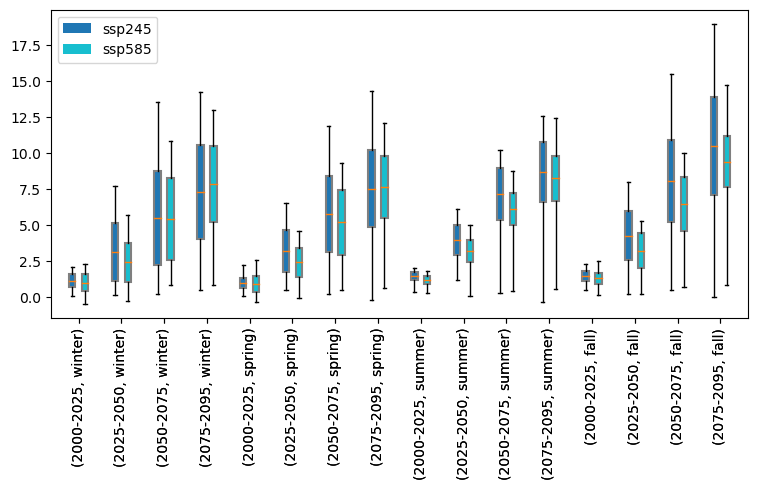

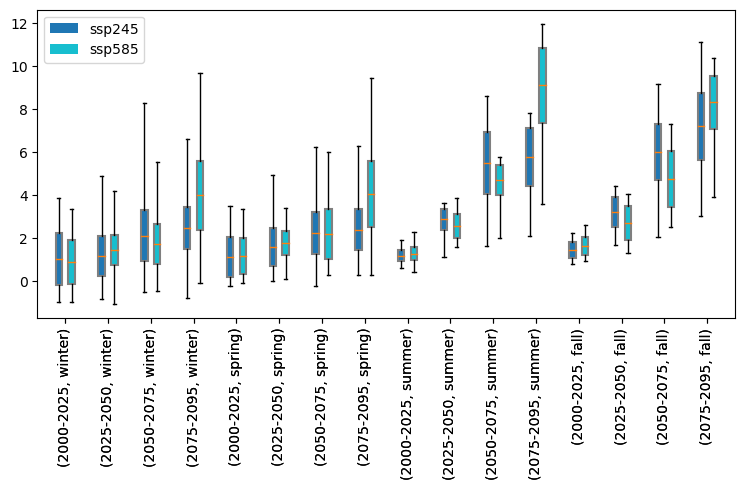

In [10]:
scenarios = ["ssp245", "ssp585"]
member_range = 12
frequency = "A"

ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                range(member_range)
                for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

# How to combine the effect of light and temp - multiplicative or additive
method="multiplicative"
methods=["multiplicative","additive"]

ds_var_names = ["hedges_temp"] #, "hedges", "hedges_light", "hedges_temp"]

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas'] #, 'Central Arctic', 'East Bering Sea']

for var_name in ds_var_names:
    for LME in LMES:
        df_list = []
        models_dict = {}

        create_maps = False
        saved_extent = None
        saved_projection = None
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            ds_list = []
            fname = "Plot/Hedges_change_{}_{}.nc".format(scenario, method)

            df, models_dict, ds_lme, extent, projection = get_area_averaged_ds(fname,
                                                                               scenario,
                                                                               var_name, LME,
                                                                               create_maps,
                                                                               frequency,
                                                                               models_dict)

            if ds_lme is not None:
                saved_extent = extent
                saved_projection = projection
                ds_lme = xr.where(((ds_lme < 1.e-20) | (ds_lme > 1e20)), np.nan, ds_lme)
                ds_list.append(ds_lme)
            create_maps = False
            if df is not None:
                df_list.append(df)
                print("Created dataframe of file: {}".format(fname))

            if len(ds_list) > 0:
                ens = ensembles.create_ensemble(ds_list).load()
                ens.close()
                ens_stats = ensembles.ensemble_mean_std_max_min(ens)

                outfile = "Figures/{}_ensemble_{}_{}.png".format(var_name.capitalize(), scenario, LME)

                plot_clim=False
                if plot_clim:
                    for clim_start_time, clim_end_time in zip(["2050-01-01", "2080-01-01"],
                                                              ["2060-01-01", "2090-01-01"]):
                        print("[CMIP6_plot] Creating climatology plot for {} to {}".format(start_time, end_time))

                        cmip6 = CMIP6_GLORYS12_plot()
                       # ens_stats = xr.where(ens_stats==0, 0, 1)

                        cmip6.plot_monthly_climatology("{}_mean".format(var_name),
                                                       "surface", "20",
                                                       ens_stats,
                                                       "Figures/",
                                                       prefix="light",
                                                       start_time=clim_start_time,
                                                       end_time=clim_end_time,
                                                       delta=True,
                                                       extent=saved_extent,
                                                       projection=saved_projection)

                #    CMIP6_ridgeplot.ridgeplot("{}_mean".format(var_name),
                #                              None, outfile,
                #                                      glorys=False, depth_threshold=None,
                #                                      ds=ens_stats)

        if len(df_list) > 0:
            df = pd.concat(df_list)

            process_data_and_create_boxplot(df, var_name, LME)

        df = pd.DataFrame()
        ds_list = []